# Question 04

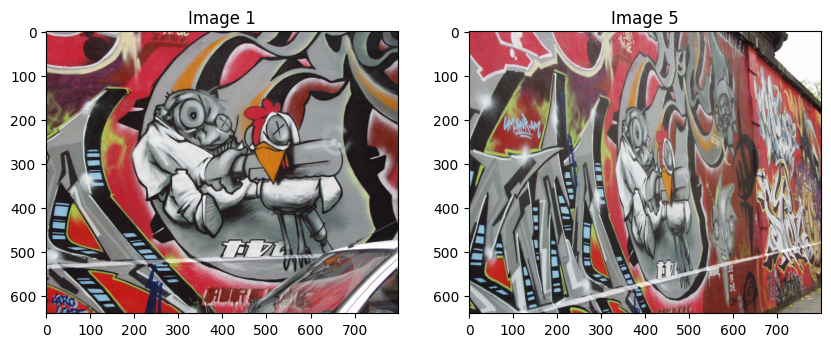

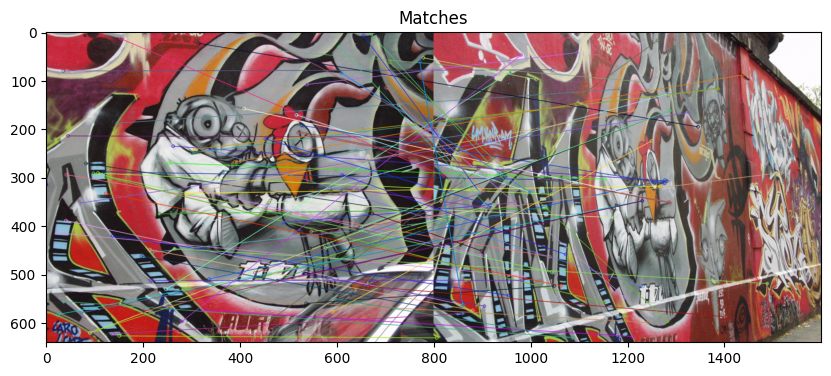

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images
img1 = cv2.imread('images\\graf\\img1.ppm', cv2.IMREAD_ANYCOLOR)
img5 = cv2.imread('images\\graf\\img5.ppm', cv2.IMREAD_ANYCOLOR)

# Plot the images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('Image 1')
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title('Image 5')
plt.imshow(cv2.cvtColor(img5, cv2.COLOR_BGR2RGB))
plt.show()

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find keypoints and descriptors in both images
k1, des1 = sift.detectAndCompute(img1, None)
k5, des5 = sift.detectAndCompute(img5, None)

# Create a brute-force matcher
bf = cv2.BFMatcher()

# Match descriptors
matches = bf.knnMatch(des1, des5, k=2)

# Apply Lowe's ratio test to filter good matches
good_matches = []
pts1 = []
pts2 = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)
        pts1.append(k1[m.queryIdx].pt)
        pts2.append(k5[m.trainIdx].pt)

# Draw the matches
match_img = cv2.drawMatches(img1, k1, img5, k5, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Save the image with matches
cv2.imwrite('matches.jpg', match_img)

# Change the image to RGB color space
#match_img = cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB)

# Plot the image with matches
plt.figure(figsize=(10, 10))
plt.title('Matches')
plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
plt.show()


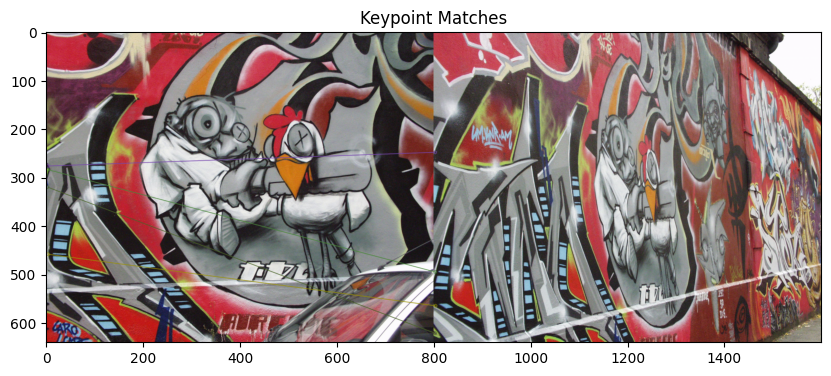

Estimated Homography Matrix:
[[ 7.09213918e-01 -1.40190868e-01  3.20441636e+01]
 [-3.12978957e+00  1.38899164e+00  1.19487979e+03]
 [ 2.16260514e-04 -6.33864575e-04  1.00000000e+00]]
Ground Truth Homography Matrix:
[[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]]


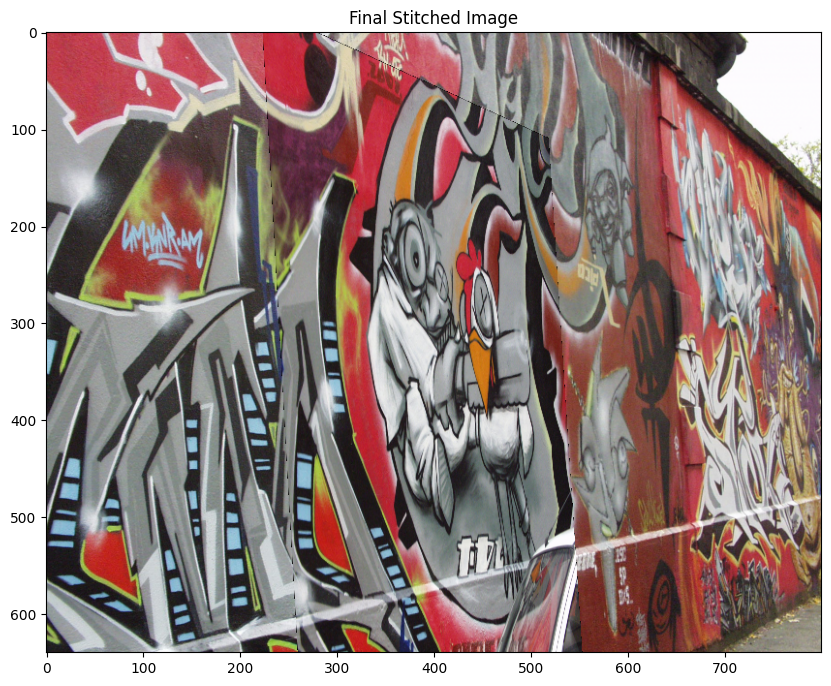

In [35]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

def custom_ransac_match(image1, image2, iterations=1000, distance_threshold=10, min_consensus_inliers=100):
    # Initialize the SIFT detector to find features
    sift_detector = cv2.SIFT_create()

    # Extract keypoints and descriptors for both images
    key_pts1, desc1 = sift_detector.detectAndCompute(image1, None)
    key_pts2, desc2 = sift_detector.detectAndCompute(image2, None)

    # Set up brute-force matcher for descriptor matching
    bf_matcher = cv2.BFMatcher()

    best_model_matches = []  # To store best matches based on RANSAC
    best_h_matrix = None  # To store the best homography transformation
    best_model_inliers = []  # To keep track of inliers for the best model

    for _ in range(iterations):
        # Randomly pick four matches to estimate the homography
        random_sample_matches = random.sample(range(len(key_pts1)), 4)

        # Get coordinates of the randomly selected keypoints
        source_pts = np.float32([key_pts1[idx].pt for idx in random_sample_matches]).reshape(-1, 1, 2)
        destination_pts = np.float32([key_pts2[idx].pt for idx in random_sample_matches]).reshape(-1, 1, 2)

        # Estimate homography matrix using the selected keypoints
        h_matrix, _ = cv2.findHomography(source_pts, destination_pts, cv2.RANSAC, distance_threshold)

        # Apply the homography transformation to the source points
        transformed_source_pts = cv2.perspectiveTransform(source_pts, h_matrix)

        # Compute Euclidean distances between transformed points and actual destination points
        point_distances = np.sqrt(np.sum((destination_pts - transformed_source_pts) ** 2, axis=2))

        # Count inliers within the specified distance threshold
        inlier_count = np.count_nonzero(point_distances < distance_threshold)

        # Update if this model has more inliers than the current best model
        if inlier_count > len(best_model_inliers):
            best_model_inliers = point_distances < distance_threshold
            best_model_matches = random_sample_matches
            best_h_matrix = h_matrix

        # Stop early if enough inliers are found
        if inlier_count >= min_consensus_inliers:
            break

    # Filter and retain only the best inlier matches
    filtered_best_matches = [cv2.DMatch(i, i, 0) for i, is_inlier in enumerate(best_model_inliers) if is_inlier]

    return filtered_best_matches, best_h_matrix, key_pts1, key_pts2


# Call the RANSAC-based matching function
good_matches, estimated_homography, kps1, kps2 = custom_ransac_match(img1, img5)

# Draw the matched keypoints on both images
match_visualization = cv2.drawMatches(img1, kps1, img5, kps2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matching keypoints between the two images
plt.figure(figsize=(10, 10))
plt.title('Keypoint Matches')
plt.imshow(cv2.cvtColor(match_visualization, cv2.COLOR_BGR2RGB))
plt.show()

print("Estimated Homography Matrix:")
print(estimated_homography)

# Load the ground truth homography matrix from a file
true_homography = np.loadtxt(r"images\\graf\\H1to5p")

# Print the actual homography matrix for comparison
print("Ground Truth Homography Matrix:")
print(true_homography)

# Use the homography to warp img1 onto img5
warped_img1 = cv2.warpPerspective(img1, true_homography, (img5.shape[1], img5.shape[0]))

# Create a binary mask for the warped image
_, mask_warped_img1 = cv2.threshold(cv2.cvtColor(warped_img1, cv2.COLOR_BGR2GRAY), 1, 255, cv2.THRESH_BINARY)

# Invert the mask to define the region of img5 where img1 will be blended
mask_img5 = cv2.bitwise_not(mask_warped_img1)

# Blend the warped img1 onto img5
result_img = cv2.bitwise_and(img5, img5, mask=mask_img5)
result_img = cv2.add(result_img, warped_img1)

# Show the final blended (stitched) image
plt.figure(figsize=(10, 10))
plt.title('Final Stitched Image')
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.show()
